In [99]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import re,os
import glob, traceback
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.dates as mdates

## 0. Read all csv files

In [100]:
df_2019 = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2019.csv')
df_2019.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_2019 = df_2019.loc[:, ~df_2019.columns.str.match('Unnamed')]
df_2019.shape

(2799726, 17)

In [101]:
df_2020 = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2020.csv')
df_2020.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_2020 = df_2020.loc[:, ~df_2020.columns.str.match('Unnamed')]
df_2020.shape

(3502171, 17)

In [102]:
df_2021 = pd.read_csv('/data2/julina/scripts/tweets/cleaned_data_by_year/2021.csv')
df_2021.drop_duplicates(subset=['text', 'created_at'], inplace=True)
df_2021 = df_2021.loc[:, ~df_2021.columns.str.match('Unnamed')]
df_2021.shape

(2553235, 17)

In [103]:
drug_keywords_map= {
'tobacco' : ['nicotine', 'tobacco', 'cigarette', 'cigarrette', 'cigar', 'bidis', 'snuff'],
'alcohol' : ['liquor', 'beer', 'wine'],
'cannabinoids' : ['marijuana', 'blunt', 'dope', 'ganja', 'grass', 'herb', 'joint', 'bud', 'mary jane', 'pot', 'reefer', 'green', 'trees', 'smoke', 'sinsemilla', 'skunk', 'weed','hashish', 'boom', 'gangster', 'hash', 'hash oil', 'hemp'],
'opioids' : ['heroin', 'smack', 'horse', 'brown sugar', 'dope', 
             # 'H',
             'junk', 'skag', 'skunk', 'white horse', 'China white','opium', 'laudanum', 'paregoric', 'big O', 'black stuff', 'block', 'gum', 'hop'],
'stimulants': ['cocaine', 'hydrochloride', 'blow', 'bump',
               # 'C',
                'candy', 'Charlie', 'coke', 'crack', 'flake', 'rock', 'snow', 'toot','amphetamine', 'Biphetamine', 'Dexedrine', 'bennies', 'black beauties', 'crosses', 'hearts', 'LA turnaround', 'speed', 'truck drivers', 'uppers','methamphetamine', 'Desoxyn','meth', 'ice', 'crank', 'chalk', 'crystal', 'fire', 'glass', 'go fast', 'speed'],
'club_drugs':['mdma', 'ecstasy', 'adam', 'clarity', 'eve', "lover's speed", 'peace', 'uppers','flunitrazepam', 'rohypnol', 'forget-me pill', 'mexican valium', 'r2', 'roach', 'roche', 'roffles', 'roofinol', 'rope', 'rophies','ghb', 'Gamma-hydroxybutyrate', 
              # 'G',
              'Georgia home boy', 'grievous bodily harm', 'liquid ecstasy', 'soap', 'scoop', 'goop', 'liquid X'],
'dissociative_drugs':['ketamine', 'Ketalar SV', 'cat Valium',
                      # 'K',
                      'Special K', 'vitamin K','pcp and analogs', 'phencyclidine' 'angel dust', 'boat', 'hog', 'love boat', 'peace pill','salvia divinorum', 'salvia', 'shepherdess’s herb', 'maria pastora', 'magic mint', 'sally-d','dextromethorphan', 'dxm',  'robotripping', 'robo', 'triple'],
'hallucinogens':['lsd','Lysergic acid diethylamide', 'acid', 'blotter', 'cubes', 'microdot', 'yellow sunshine', 'blue heaven', 'mescaline', 'Buttons', 'cactus', 'mesc', 'peyote', 'psilocybin', 'Magic mushrooms', 'purple passion', 'shrooms', 'little smoke'],
'other_compounds':['anabolic_steroids', 'Anadrol', 'Oxandrin', 'Durabolin', 'Depo-Testosterone', 'Equipoise', 'roids', 'juice', 'gym candy', 'pumpers','inhalants', 'Solvents', 'paint thinners', 'gasoline', 'glues', 'gasses', 'butane', 'propane', 'aerosol propellants', 'nitrous oxide',  'nitrites' ,'isoamyl', 'isobutyl', 'cyclohexyl','laughing gas', 'poppers', 'snappers', 'whippets'],
'prescription_medications':['cns_depressants', 'stimulants', 'opioid pain relievers', 'OxyContin','Oxycodone', 'Vicodin', 'Norco', 'Lortab', 'Hydrocodone', 'Acetaminophen', 'Percocet ', 'Oxycodone', 'Acetaminophen','Tramadol','Codeine','Morphine','Methadone','Demerol', 'meperidine','Acetaminophen','Tylenol', 'Excedrin', 'Vanquish','Aspirin', 'Bayer', 'Bufferin', 'Ecotrin', 'Excedrin', 'Vanquish','Diclofenac', 'Voltaren Gel','Ibuprofen', 'Advil', 'Motrin IB','Naproxen', 'Aleve']
}

drug_cols = drug_keywords_map.keys()

In [104]:
# https://nida.nih.gov/sites/default/files/cadchart.pdf
for keyword, words in drug_keywords_map.items():
    pattern = fr'\b(?:{"|".join(words)})\b'
    # print(f'Keyword: {keyword}, Pattern: {pattern}')
    df_2019[keyword] = df_2019['text'].str.contains(pattern, case=False).astype(int)
    df_2020[keyword] = df_2020['text'].str.contains(pattern, case=False).astype(int)
    df_2021[keyword] = df_2021['text'].str.contains(pattern, case=False).astype(int)

In [105]:
drug_cols = list(drug_keywords_map.keys())

In [106]:
df_2019['drug_type'] = df_2019[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2020['drug_type'] = df_2020[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)
df_2021['drug_type'] = df_2021[drug_cols].apply(lambda row: next((col for col, val in zip(drug_cols, row) if val == 1), None), axis=1)

In [107]:
# df_2019['drug_type'].value_counts(), df_2020['drug_type'].value_counts(), df_2021['drug_type'].value_counts()

## 1. Aggregation by post 

In [110]:
data = [df_2019, df_2020, df_2021]
years = [2019, 2020, 2021]

age_groups = ['<=18','19-29', '30-39', '>=40']
# race_groups = ['api', 'white', 'hispanic', 'black']
metrics = ['Total Tweets', 'Org', 'Person', 'Female', 'Male', 
           'Teenage', 'Adult', 'Teenage Female', 'Teenage Male', 'Adult Female', 'Adult Male'] + age_groups + ['Neutral', 'Positive', 'Negative'] 
# +race_groups 
            
results = {metric: [] for metric in metrics}

for i in range(3):
    dff = data[i]
    year = years[i]
    is_org = dff[dff['org'] == 'is-org']
    non_org = dff[dff['org'] != 'is-org']
    
    total_tweets = dff.shape[0]
    count_is_org = is_org.shape[0]
    count_non_org = non_org.shape[0]
    percent_is_org = (count_is_org / total_tweets) * 100
    percent_non_org = (count_non_org / total_tweets) * 100

    total_user_tweets = count_non_org
    total_female_tweets = non_org[non_org['gender'] == 'female'].shape[0]
    total_male_tweets = non_org[non_org['gender'] == 'male'].shape[0]
    percent_female = (total_female_tweets / total_user_tweets) * 100
    percent_male = (total_male_tweets / total_user_tweets) * 100

    total_teenagers_tweets = non_org[non_org['is_teenage'] == 1].shape[0]
    total_adult_tweets = non_org[non_org['is_teenage'] != 1].shape[0]
    percent_teenage = (total_teenagers_tweets / total_user_tweets) * 100
    percent_adult = (total_adult_tweets / total_user_tweets) * 100

    tf = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'female')].shape[0]
    tm = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'male')].shape[0]
    af = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'female')].shape[0]
    am = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'male')].shape[0]
    percent_tf = (tf / total_user_tweets) * 100
    percent_tm = (tm / total_user_tweets) * 100
    percent_af = (af / total_user_tweets) * 100
    percent_am = (am / total_user_tweets) * 100
    
    total_neu_tweets = dff[(dff['sentiment'] == 'neu')].shape[0]
    total_pos_tweets = dff[(dff['sentiment'] == 'pos')].shape[0]
    total_neg_tweets = dff[(dff['sentiment'] == 'neg')].shape[0]
    percent_neu = (total_neu_tweets / total_tweets) * 100
    percent_pos = (total_pos_tweets / total_tweets) * 100
    percent_neg = (total_neg_tweets / total_tweets) * 100
    
    totals = {}
    percentages = {}
    for age_group in age_groups:
        totals[age_group] = non_org[non_org['age'] == age_group].shape[0]
        percentages[age_group] = (totals[age_group] / non_org.shape[0]) * 100
    
    # for race in race_groups:
    #     totals[race] = non_org[non_org['race'] == race].shape[0]
    #     percentages[race] = (totals[race] / non_org.shape[0]) * 100
    
    results['Total Tweets'].append(total_tweets)
    results['Org'].append(f"{count_is_org} ({percent_is_org:.2f}%)")
    results['Person'].append(f"{count_non_org} ({percent_non_org:.2f}%)")
    # results['Non Org User Tweets'].append(total_user_tweets)
    results['Female'].append(f"{total_female_tweets} ({percent_female:.2f}%)")
    results['Male'].append(f"{total_male_tweets} ({percent_male:.2f}%)")
    results['Teenage'].append(f"{total_teenagers_tweets} ({percent_teenage:.2f}%)")
    results['Adult'].append(f"{total_adult_tweets} ({percent_adult:.2f}%)")
    results['Teenage Female'].append(f"{tf} ({percent_tf:.2f}%)")
    results['Teenage Male'].append(f"{tm} ({percent_tm:.2f}%)")
    results['Adult Female'].append(f"{af} ({percent_af:.2f}%)")
    results['Adult Male'].append(f"{am} ({percent_am:.2f}%)")
    
    results['Neutral'].append(f"{total_neu_tweets} ({percent_neu:.2f}%)")
    results['Positive'].append(f"{total_pos_tweets} ({percent_pos:.2f}%)")
    results['Negative'].append(f"{total_neg_tweets} ({percent_neg:.2f}%)")
    
    for age_group in age_groups:
        results[f"{age_group}"].append(f"{totals[age_group]} ({percentages[age_group]:.2f}%)")

    # for race in race_groups:
    #     results[f"{race}"].append(f"{totals[race]} ({percentages[race]:.2f}%)")
        
# Convert results to DataFrame
results_df = pd.DataFrame(results, index=years).T

# Print the pivoted DataFrame
print(results_df)

                            2019              2020              2021
Total Tweets             2799726           3502171           2553235
Org               221934 (7.93%)    291136 (8.31%)    232207 (9.09%)
Person          2577792 (92.07%)  3211035 (91.69%)  2321028 (90.91%)
Female          1318063 (51.13%)  1558219 (48.53%)  1081682 (46.60%)
Male            1259729 (48.87%)  1652816 (51.47%)  1239346 (53.40%)
Teenage         1019817 (39.56%)  1257269 (39.15%)   968414 (41.72%)
Adult           1557975 (60.44%)  1953766 (60.85%)  1352614 (58.28%)
Teenage Female   609320 (23.64%)   711873 (22.17%)   534702 (23.04%)
Teenage Male     410497 (15.92%)   545396 (16.99%)   433712 (18.69%)
Adult Female     708743 (27.49%)   846346 (26.36%)   546980 (23.57%)
Adult Male       849232 (32.94%)  1107420 (34.49%)   805634 (34.71%)
<=18            1019817 (39.56%)  1257269 (39.15%)   968414 (41.72%)
19-29            772388 (29.96%)   849019 (26.44%)   542770 (23.38%)
30-39            468354 (18.17%)  

In [113]:
results_df.to_csv('demo_dist_agg_by_post.csv')

# 2. Drug Distribution by age group

In [111]:
data = [df_2019, df_2020, df_2021]
years = [2019, 2020, 2021]

# Initialize an empty dictionary to collect results
results_dict = {}
age_groups = ['<=18','19-29', '30-39', '>=40']
# race_groups = ['api', 'white', 'hispanic', 'black']


for i in range(3):
    year = years[i]
    dff = data[i]
    
    org = dff[dff['org'] == 'is-org']
    non_org = dff[dff['org'] != 'is-org']
    
    female = non_org[(non_org['gender'] == 'female')]
    male = non_org[(non_org['gender'] == 'male')]
    adult = non_org[(non_org['is_teenage'] == 1)]
    teenage = non_org[(non_org['is_teenage'] != 1)]
    
    to_value_counts = dff['drug_type'].value_counts()
    to_percentages = (to_value_counts / dff.shape[0]) * 100
    
    o_value_counts = org['drug_type'].value_counts()
    p_value_counts = non_org['drug_type'].value_counts()
    o_percentages = (o_value_counts / dff.shape[0]) * 100
    p_percentages = (p_value_counts /dff.shape[0]) * 100
    
    f_value_counts = female['drug_type'].value_counts()
    m_value_counts = male['drug_type'].value_counts()
    f_percentages = (f_value_counts / dff.shape[0]) * 100
    m_percentages = (m_value_counts / dff.shape[0]) * 100
   
    a_value_counts = adult['drug_type'].value_counts()
    t_value_counts = teenage['drug_type'].value_counts()
    a_percentages = (a_value_counts / dff.shape[0]) * 100
    t_percentages = (t_value_counts / dff.shape[0]) * 100
    
    value_counts = {}
    percentages = {}
    for age_group in age_groups:
        age_filter = non_org[non_org['age'] == age_group]
        value_counts[age_group] = age_filter['drug_type'].value_counts()
        percentages[age_group] = (value_counts[age_group] / dff.shape[0]) * 100
    
    # for race in race_groups:
    #     race_filter = non_org[non_org['race'] == race]
    #     value_counts[race] = race_filter['drug_type'].value_counts()
    #     percentages[race] = (value_counts[race] / non_org.shape[0]) * 100

    # Combine the counts and percentages into a DataFrame
    result = pd.DataFrame({
        f'Total {year}': to_value_counts.astype(int).astype(str) + ' (' + to_percentages.map('{:.2f}%'.format) + ')',        
        f'Org {year}': o_value_counts.astype(int).astype(str) + ' (' + o_percentages.map('{:.2f}%'.format) + ')',        
        f'Person {year}': p_value_counts.astype(int).astype(str) + ' (' + p_percentages.map('{:.2f}%'.format) + ')',        
        f'Female {year}': f_value_counts.astype(int).astype(str) + ' (' + f_percentages.map('{:.2f}%'.format) + ')',
        f'Male {year}': m_value_counts.astype(int).astype(str) + ' (' + m_percentages.map('{:.2f}%'.format) + ')',
        f'Adult {year}': a_value_counts.astype(int).astype(str) + ' (' + a_percentages.map('{:.2f}%'.format) + ')',
        f'Teenage {year}': t_value_counts.astype(int).astype(str) + ' (' + t_percentages.map('{:.2f}%'.format) + ')'
    })

    for age_group in age_groups:
        result[f'{age_group} {year}'] = value_counts[age_group].astype(int).astype(str) + ' (' + percentages[age_group].map('{:.2f}%'.format) + ')'

    # for race in race_groups:
    #     result[f'{race} {year}'] = value_counts[race].astype(int).astype(str) + ' (' + percentages[race].map('{:.2f}%'.format) + ')'
    # Fill NaN values with 0 for better readability
    result = result.fillna('0 (0.00%)')

    # Add the result to the dictionary
    results_dict[year] = result

# Concatenate all results along columns
combined_result = pd.concat(results_dict.values(), axis=1)

# Prepare multi-index for columns
columns = pd.MultiIndex.from_product([combined_result.index, years], names=['Drug', 'Year'])

In [119]:
df=results_dict[2020].T
df.to_csv('2020_by_demo_drug.csv')

In [120]:
df=results_dict[2019].T
df.to_csv('2019_by_demo_drug.csv')

In [121]:
df=results_dict[2021].T
df.to_csv('2021_by_demo_drug.csv')

In [112]:
# Reorganize the DataFrame to have drug types as columns and two rows for male and female
groups = ['Total', 'Org', 'Person', 'Female', 'Male', 'Adult', 'Teenage', '<=18','19-29', '30-39', '>=40', 'Total']
final_result = pd.DataFrame(index= groups, columns=columns)

for drug_type in combined_result.index:
    for year in years:
        final_result[(drug_type, year)] = [
        
            combined_result.at[drug_type, f'Total {year}'],
            combined_result.at[drug_type, f'Org {year}'],
            combined_result.at[drug_type, f'Person {year}'],
            combined_result.at[drug_type, f'Female {year}'],
            combined_result.at[drug_type, f'Male {year}'],
            combined_result.at[drug_type, f'Teenage {year}'],
            combined_result.at[drug_type, f'Adult {year}'],
            combined_result.at[drug_type, f'<=18 {year}'],
            combined_result.at[drug_type, f'19-29 {year}'],
            combined_result.at[drug_type, f'30-39 {year}'],
            combined_result.at[drug_type, f'>=40 {year}'],
            
            # combined_result.at[drug_type, f'api {year}'],
            # combined_result.at[drug_type, f'white {year}'],
            # combined_result.at[drug_type, f'black {year}'],
            # combined_result.at[drug_type, f'hispanic {year}'],
            
            combined_result.at[drug_type, f'Total {year}'],
        ]

# Display the final result
# print(final_result)

In [114]:
final_result.to_csv('drug_by_demo.csv')

In [115]:
final_result

Drug             alcohol                                       cannabinoids  \
Year                2019             2020             2021             2019   
Total    291510 (10.41%)  361702 (10.33%)  257560 (10.09%)  443227 (15.83%)   
Org        40018 (1.43%)    43405 (1.24%)    32835 (1.29%)    24348 (0.87%)   
Person    251492 (8.98%)   318297 (9.09%)   224725 (8.80%)  418879 (14.96%)   
Female    119112 (4.25%)   148054 (4.23%)    99981 (3.92%)   202986 (7.25%)   
Male      132380 (4.73%)   170243 (4.86%)   124744 (4.89%)   215893 (7.71%)   
Adult     172747 (6.17%)   217706 (6.22%)   147245 (5.77%)   245817 (8.78%)   
Teenage    78745 (2.81%)   100591 (2.87%)    77480 (3.03%)   173062 (6.18%)   
<=18       78745 (2.81%)   100591 (2.87%)    77480 (3.03%)   173062 (6.18%)   
19-29      67800 (2.42%)    80445 (2.30%)    49397 (1.93%)   139944 (5.00%)   
30-39      60819 (2.17%)    79244 (2.26%)    57028 (2.23%)    68293 (2.44%)   
>=40       44128 (1.58%)    58017 (1.66%)    40820 (1.60%)    37580 (1.34%)   
Total    291510 (10.41%)  361702 (10.33%)  257560 (10.09%)  443227 (15.83%)   

Drug                                         club_drugs                \
Year                2020             2021          2019          2020   
Total    527044 (15.05%)  348688 (13.66%)  8421 (0.30%)  8444 (0.24%)   
Org        32433 (0.93%)    25924 (1.02%)   609 (0.02%)  1061 (0.03%)   
Person   494611 (14.12%)  322764 (12.64%)  7812 (0.28%)  7383 (0.21%)   
Female    227746 (6.50%)   142849 (5.59%)  4474 (0.16%)  3684 (0.11%)   
Male      266865 (7.62%)   179915 (7.05%)  3338 (0.12%)  3699 (0.11%)   
Adult     293732 (8.39%)   190757 (7.47%)  4614 (0.16%)  4881 (0.14%)   
Teenage   200879 (5.74%)   132007 (5.17%)  3198 (0.11%)  2502 (0.07%)   
<=18      200879 (5.74%)   132007 (5.17%)  3198 (0.11%)  2502 (0.07%)   
19-29     153386 (4.38%)    89152 (3.49%)  2472 (0.09%)  1706 (0.05%)   
30-39      88661 (2.53%)    64713 (2.53%)  1222 (0.04%)  1687 (0.05%)   
>=40       51685 (1.48%)    36892 (1.44%)   920 (0.03%)  1488 (0.04%)   
Total    527044 (15.05%)  348688 (13.66%)  8421 (0.30%)  8444 (0.24%)   

Drug                  dissociative_drugs  ... other_compounds  \
Year             2021               2019  ...            2021   
Total    6054 (0.24%)       1527 (0.05%)  ...    3551 (0.14%)   
Org       527 (0.02%)        188 (0.01%)  ...     214 (0.01%)   
Person   5527 (0.22%)       1339 (0.05%)  ...    3337 (0.13%)   
Female   2828 (0.11%)        655 (0.02%)  ...    1731 (0.07%)   
Male     2699 (0.11%)        684 (0.02%)  ...    1606 (0.06%)   
Adult    3208 (0.13%)        922 (0.03%)  ...    1739 (0.07%)   
Teenage  2319 (0.09%)        417 (0.01%)  ...    1598 (0.06%)   
<=18     2319 (0.09%)        417 (0.01%)  ...    1598 (0.06%)   
19-29    1333 (0.05%)        389 (0.01%)  ...     824 (0.03%)   
30-39    1092 (0.04%)        291 (0.01%)  ...     598 (0.02%)   
>=40      783 (0.03%)        242 (0.01%)  ...     317 (0.01%)   
Total    6054 (0.24%)       1527 (0.05%)  ...    3551 (0.14%)   

Drug    prescription_medications                                  stimulants  \
Year                        2019          2020          2021            2019   
Total               2084 (0.07%)  4582 (0.13%)  1981 (0.08%)  173502 (6.20%)   
Org                  230 (0.01%)   315 (0.01%)   224 (0.01%)   13837 (0.49%)   
Person              1854 (0.07%)  4267 (0.12%)  1757 (0.07%)  159665 (5.70%)   
Female               879 (0.03%)  2195 (0.06%)   834 (0.03%)   76578 (2.74%)   
Male                 975 (0.03%)  2072 (0.06%)   923 (0.04%)   83087 (2.97%)   
Adult               1279 (0.05%)  2562 (0.07%)  1133 (0.04%)   97478 (3.48%)   
Teenage              575 (0.02%)  1705 (0.05%)   624 (0.02%)   62187 (2.22%)   
<=18                 575 (0.02%)  1705 (0.05%)   624 (0.02%)   62187 (2.22%)   
19-29                461 (0.02%)  1247 (0.04%)   309 (0.01%)   44572 (1.59%)   
30-39                440 (0.02%)   828 (0.02%)   451 (0.02%)   30597 (1.09%)   

In [ ]:
alcohol = final_result['alcohol']
alcohol

In [70]:
alcohol.to_csv('output/alcohol.csv')

In [ ]:
cannabinoids = final_result['cannabinoids']
cannabinoids
# cannabinoids.to_csv('cannabinoids.csv')

In [ ]:
prescription_medications = final_result['prescription_medications']
prescription_medications
# prescription_medications.to_csv('prescription_medications.csv')

In [ ]:
stimulants = final_result['stimulants']
stimulants

In [ ]:
stimulants.to_csv('stimulants.csv')

In [ ]:
opioids = final_result['opioids']
opioids

In [ ]:
tobacco = final_result['tobacco']
tobacco

In [ ]:
hallucinogens = final_result['hallucinogens']
hallucinogens

In [152]:
results_dict = {}
result = pd.DataFrame({
    '2019': df_2019['drug_type'].value_counts(),
    '2020': df_2020['drug_type'].value_counts(),
    '2021':  df_2021['drug_type'].value_counts()
    })
results_dict['drug_type'] = result
result = pd.DataFrame({
    '2019': df_2019['race'].value_counts(),
    '2020': df_2020['race'].value_counts(),
    '2021':  df_2021['race'].value_counts()
    })
results_dict['race'] = result
combined_result = pd.concat(results_dict.values(), axis=0) #axis=1
combined_result

,2019,2020,2021
cannabinoids,151674,199597,149544
alcohol,137615,175067,130046
stimulants,67988,86570,71597
tobacco,25594,30345,25299
opioids,11527,12536,11522
club_drugs,2411,3729,2656
other_compounds,1873,2481,1773
prescription_medications,997,1321,1091
dissociative_drugs,777,928,815
hallucinogens,379,513,443


## 4. Aggregation by USER


In [ ]:
non_org['user_id'].nunique()

In [124]:
data = [df_2019, df_2020, df_2021]
years = [2019, 2020, 2021]

age_groups = ['<=18','19-29', '30-39', '>=40']
# race_groups = ['api', 'white', 'hispanic', 'black']
metrics = ['Total Users', 'Org', 'Person', 'Female', 'Male', 
           'Teenage', 'Adult', 'Teenage Female', 'Teenage Male', 'Adult Female', 'Adult Male'] + age_groups + ['Neutral', 'Positive', 'Negative'] 
# +race_groups 
            
results = {metric: [] for metric in metrics}

for i in range(3):
    dff = data[i]
    year = years[i]
    dff = dff.drop_duplicates(subset=['user_id'], keep='first')
    is_org = dff[dff['org'] == 'is-org']
    non_org = dff[dff['org'] != 'is-org']
        
    total_tweets = dff.shape[0]
    count_is_org = is_org.shape[0]
    count_non_org = non_org.shape[0]
    percent_is_org = (count_is_org / total_tweets) * 100
    percent_non_org = (count_non_org / total_tweets) * 100

    total_user_tweets = count_non_org
    total_female_tweets = non_org[non_org['gender'] == 'female'].shape[0]
    total_male_tweets = non_org[non_org['gender'] == 'male'].shape[0]
    percent_female = (total_female_tweets / total_user_tweets) * 100
    percent_male = (total_male_tweets / total_user_tweets) * 100

    total_teenagers_tweets = non_org[non_org['is_teenage'] == 1].shape[0]
    total_adult_tweets = non_org[non_org['is_teenage'] != 1].shape[0]
    percent_teenage = (total_teenagers_tweets / total_user_tweets) * 100
    percent_adult = (total_adult_tweets / total_user_tweets) * 100

    tf = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'female')].shape[0]
    tm = non_org[(non_org['is_teenage'] == 1) & (non_org['gender'] == 'male')].shape[0]
    af = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'female')].shape[0]
    am = non_org[(non_org['is_teenage'] != 1) & (non_org['gender'] == 'male')].shape[0]
    percent_tf = (tf / total_user_tweets) * 100
    percent_tm = (tm / total_user_tweets) * 100
    percent_af = (af / total_user_tweets) * 100
    percent_am = (am / total_user_tweets) * 100
    
    total_neu_tweets = dff[(dff['sentiment'] == 'neu')].shape[0]
    total_pos_tweets = dff[(dff['sentiment'] == 'pos')].shape[0]
    total_neg_tweets = dff[(dff['sentiment'] == 'neg')].shape[0]
    percent_neu = (total_neu_tweets / total_tweets) * 100
    percent_pos = (total_pos_tweets / total_tweets) * 100
    percent_neg = (total_neg_tweets / total_tweets) * 100
    
    totals = {}
    percentages = {}
    for age_group in age_groups:
        totals[age_group] = non_org[non_org['age'] == age_group].shape[0]
        percentages[age_group] = (totals[age_group] / non_org.shape[0]) * 100
    
    # for race in race_groups:
    #     totals[race] = non_org[non_org['race'] == race].shape[0]
    #     percentages[race] = (totals[race] / non_org.shape[0]) * 100
    
    results['Total Users'].append(total_tweets)
    results['Org'].append(f"{count_is_org} ({percent_is_org:.2f}%)")
    results['Person'].append(f"{count_non_org} ({percent_non_org:.2f}%)")
    # results['Non Org User Tweets'].append(total_user_tweets)
    results['Female'].append(f"{total_female_tweets} ({percent_female:.2f}%)")
    results['Male'].append(f"{total_male_tweets} ({percent_male:.2f}%)")
    results['Teenage'].append(f"{total_teenagers_tweets} ({percent_teenage:.2f}%)")
    results['Adult'].append(f"{total_adult_tweets} ({percent_adult:.2f}%)")
    results['Teenage Female'].append(f"{tf} ({percent_tf:.2f}%)")
    results['Teenage Male'].append(f"{tm} ({percent_tm:.2f}%)")
    results['Adult Female'].append(f"{af} ({percent_af:.2f}%)")
    results['Adult Male'].append(f"{am} ({percent_am:.2f}%)")
    
    results['Neutral'].append(f"{total_neu_tweets} ({percent_neu:.2f}%)")
    results['Positive'].append(f"{total_pos_tweets} ({percent_pos:.2f}%)")
    results['Negative'].append(f"{total_neg_tweets} ({percent_neg:.2f}%)")
    
    for age_group in age_groups:
        results[f"{age_group}"].append(f"{totals[age_group]} ({percentages[age_group]:.2f}%)")

    # for race in race_groups:
    #     results[f"{race}"].append(f"{totals[race]} ({percentages[race]:.2f}%)")
        
# Convert results to DataFrame
results_df = pd.DataFrame(results, index=years).T

# Print the pivoted DataFrame
print(results_df)

                            2019              2020              2021
Total Users              2131457           2604123           1946742
Org               153779 (7.21%)    195648 (7.51%)    159816 (8.21%)
Person          1977678 (92.79%)  2408475 (92.49%)  1786926 (91.79%)
Female          1007368 (50.94%)  1166535 (48.43%)   828102 (46.34%)
Male             970310 (49.06%)  1241940 (51.57%)   958824 (53.66%)
Teenage          793067 (40.10%)   970641 (40.30%)   759859 (42.52%)
Adult           1184611 (59.90%)  1437834 (59.70%)  1027067 (57.48%)
Teenage Female   473016 (23.92%)   551184 (22.89%)   419419 (23.47%)
Teenage Male     320051 (16.18%)   419457 (17.42%)   340440 (19.05%)
Adult Female     534352 (27.02%)   615351 (25.55%)   408683 (22.87%)
Adult Male       650259 (32.88%)   822483 (34.15%)   618384 (34.61%)
<=18             793067 (40.10%)   970641 (40.30%)   759859 (42.52%)
19-29            587274 (29.70%)   633760 (26.31%)   419018 (23.45%)
30-39            361423 (18.28%)  

In [125]:
results_df.to_csv('demo_dist_agg_by_user.csv')

In [126]:
data = [df_2019, df_2020, df_2021]
years = [2019, 2020, 2021]

# Initialize an empty dictionary to collect results
results_dict = {}
age_groups = ['<=18','19-29', '30-39', '>=40']
# race_groups = ['api', 'white', 'hispanic', 'black']


for i in range(3):
    year = years[i]
    dff = data[i]
    dff = dff.drop_duplicates(subset=['user_id'], keep='first')

    org = dff[dff['org'] == 'is-org']
    non_org = dff[dff['org'] != 'is-org']
    
    female = non_org[(non_org['gender'] == 'female')]
    male = non_org[(non_org['gender'] == 'male')]
    adult = non_org[(non_org['is_teenage'] == 1)]
    teenage = non_org[(non_org['is_teenage'] != 1)]
    
    to_value_counts = dff['drug_type'].value_counts()
    to_percentages = (to_value_counts / dff.shape[0]) * 100
    
    o_value_counts = org['drug_type'].value_counts()
    p_value_counts = non_org['drug_type'].value_counts()
    o_percentages = (o_value_counts / dff.shape[0]) * 100
    p_percentages = (p_value_counts /dff.shape[0]) * 100
    
    f_value_counts = female['drug_type'].value_counts()
    m_value_counts = male['drug_type'].value_counts()
    f_percentages = (f_value_counts / dff.shape[0]) * 100
    m_percentages = (m_value_counts / dff.shape[0]) * 100
   
    a_value_counts = adult['drug_type'].value_counts()
    t_value_counts = teenage['drug_type'].value_counts()
    a_percentages = (a_value_counts / dff.shape[0]) * 100
    t_percentages = (t_value_counts / dff.shape[0]) * 100
    
    value_counts = {}
    percentages = {}
    for age_group in age_groups:
        age_filter = non_org[non_org['age'] == age_group]
        value_counts[age_group] = age_filter['drug_type'].value_counts()
        percentages[age_group] = (value_counts[age_group] / dff.shape[0]) * 100
    
    # for race in race_groups:
    #     race_filter = non_org[non_org['race'] == race]
    #     value_counts[race] = race_filter['drug_type'].value_counts()
    #     percentages[race] = (value_counts[race] / non_org.shape[0]) * 100

    # Combine the counts and percentages into a DataFrame
    result = pd.DataFrame({
        f'Total {year}': to_value_counts.astype(int).astype(str) + ' (' + to_percentages.map('{:.2f}%'.format) + ')',        
        f'Org {year}': o_value_counts.astype(int).astype(str) + ' (' + o_percentages.map('{:.2f}%'.format) + ')',        
        f'Person {year}': p_value_counts.astype(int).astype(str) + ' (' + p_percentages.map('{:.2f}%'.format) + ')',        
        f'Female {year}': f_value_counts.astype(int).astype(str) + ' (' + f_percentages.map('{:.2f}%'.format) + ')',
        f'Male {year}': m_value_counts.astype(int).astype(str) + ' (' + m_percentages.map('{:.2f}%'.format) + ')',
        f'Adult {year}': a_value_counts.astype(int).astype(str) + ' (' + a_percentages.map('{:.2f}%'.format) + ')',
        f'Teenage {year}': t_value_counts.astype(int).astype(str) + ' (' + t_percentages.map('{:.2f}%'.format) + ')'
    })

    for age_group in age_groups:
        result[f'{age_group} {year}'] = value_counts[age_group].astype(int).astype(str) + ' (' + percentages[age_group].map('{:.2f}%'.format) + ')'

    # for race in race_groups:
    #     result[f'{race} {year}'] = value_counts[race].astype(int).astype(str) + ' (' + percentages[race].map('{:.2f}%'.format) + ')'
    # Fill NaN values with 0 for better readability
    result = result.fillna('0 (0.00%)')

    # Add the result to the dictionary
    results_dict[year] = result

# Concatenate all results along columns
combined_result = pd.concat(results_dict.values(), axis=1)

# Prepare multi-index for columns
columns = pd.MultiIndex.from_product([combined_result.index, years], names=['Drug', 'Year'])

In [127]:
df=results_dict[2020].T
df.to_csv('2020_by_demo_drug_agg_by_user.csv')

# Radar plot

In [263]:
data = [df_2019, df_2020, df_2021]
years = [2019, 2020, 2021]
unique_emotions = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']

all_data = {y: {} for y in years}
age_groups = ['<=18','19-29', '30-39', '>=40']
race_groups = ['api', 'white', 'hispanic', 'black']
metrics = ['Org', 'Person', 'Female', 'Male'] + age_groups + race_groups 

for i in range(3):
    result_map = {metric: [] for metric in metrics}
    year = years[i]
    dff = data[i]
    for emotion in unique_emotions:
        dff[emotion] = dff['emotion'].apply(lambda x: 1 if emotion in x else 0)
    
    o = dff[dff['org'] =='is-org']
    p = dff[dff['org'] !='is-org']
    
    m = p[p['gender'] =='male']
    f = p[p['gender'] =='female']
    
    ages = {}
    for age in age_groups:
        ages[age] = p[p['age'] == age]
    
    races = {}
    for race in race_groups:
        races[race] = p[p['race'] == race]
        
    result_map['Org'] = o[list(unique_emotions)].mean().round(3)
    result_map['Person']  = p[list(unique_emotions)].mean().round(3)
    result_map['Male']  = m[list(unique_emotions)].mean().round(3)
    result_map['Female']  = f[list(unique_emotions)].mean().round(3)
    
    for age in age_groups:
        result_map[age] = ages[age][list(unique_emotions)].mean().round(3)
    
    for race in race_groups:
        result_map[race] = races[race][list(unique_emotions)].mean().round(3)
    
    all_data[year] = result_map
    # combined_result = pd.concat(all_data[year], axis=1) 
    # print(combined_result)

In [264]:
combined_result = pd.concat(all_data[2019], axis=1) #axis=1
combined_result

,Org,Person,Female,Male,<=18,19-29,30-39,>=40,api,white,hispanic,black
anger,0.203,0.267,0.260,0.272,0.267,0.279,0.249,0.273,0.263,0.268,0.260,0.250
anticipation,0.056,0.035,0.033,0.036,0.030,0.033,0.039,0.040,0.030,0.036,0.034,0.032
disgust,0.255,0.324,0.317,0.329,0.323,0.334,0.306,0.335,0.321,0.325,0.316,0.307
fear,0.010,0.013,0.015,0.011,0.014,0.013,0.012,0.012,0.014,0.013,0.012,0.013
hopeless,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
joy,0.336,0.267,0.279,0.257,0.258,0.266,0.285,0.261,0.257,0.269,0.268,0.265
love,0.014,0.019,0.023,0.015,0.021,0.020,0.017,0.014,0.020,0.018,0.020,0.017
optimism,0.168,0.125,0.129,0.122,0.118,0.119,0.136,0.134,0.124,0.125,0.126,0.137
sadness,0.030,0.050,0.058,0.043,0.056,0.056,0.042,0.038,0.056,0.048,0.049,0.047
surprise,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.001


In [265]:
combined_result = pd.concat(all_data[2021], axis=1) #axis=1
combined_result

,Org,Person,Female,Male,<=18,19-29,30-39,>=40,api,white,hispanic,black
anger,0.206,0.242,0.233,0.249,0.235,0.256,0.235,0.253,0.235,0.244,0.235,0.242
anticipation,0.053,0.036,0.034,0.038,0.032,0.034,0.041,0.041,0.032,0.037,0.036,0.037
disgust,0.266,0.302,0.292,0.310,0.293,0.312,0.296,0.323,0.294,0.305,0.294,0.311
fear,0.012,0.015,0.017,0.013,0.016,0.015,0.013,0.012,0.014,0.015,0.015,0.015
hopeless,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.000
joy,0.283,0.261,0.275,0.251,0.260,0.266,0.271,0.245,0.259,0.262,0.263,0.251
love,0.013,0.018,0.023,0.015,0.020,0.020,0.016,0.013,0.019,0.018,0.019,0.018
optimism,0.150,0.130,0.133,0.127,0.125,0.126,0.138,0.133,0.132,0.129,0.133,0.141
sadness,0.032,0.051,0.059,0.044,0.058,0.056,0.043,0.038,0.055,0.050,0.050,0.053
surprise,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.001,0.001,0.001,0.002


In [272]:
font1 = {'family': 'DejaVu Sans',
         'weight': 'normal',
         'size'  : 20}
font2 = {'family': 'DejaVu Sans',
         'weight': 'normal',
         'size'  : 15}
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
red_rgb = '#E24A33'
blue_rgb = '#348ABD'
green_rgb = '#32CD32'
yellow_rgb = '#FFD700'
feature = ['anger', 'anticipation', 'disgust', 'fear', 'hopeless', 'joy', 'love', 'optimism', 'sadness', 'surprise', 'trust']
N = len(feature)

ylim = [0.4, 0.4, 0.25, 0.25]
colors = [blue_rgb, red_rgb, green_rgb, yellow_rgb]
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

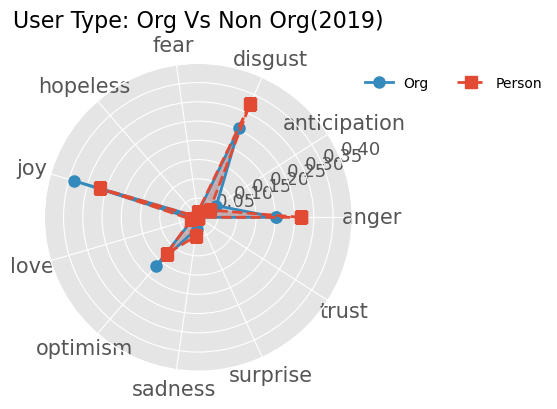

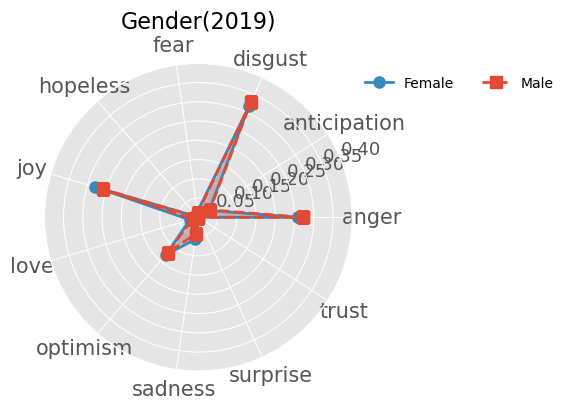

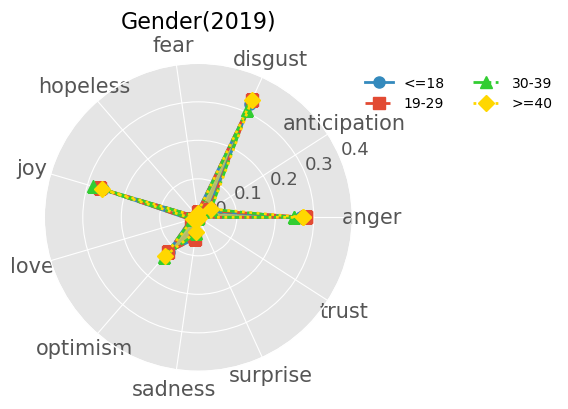

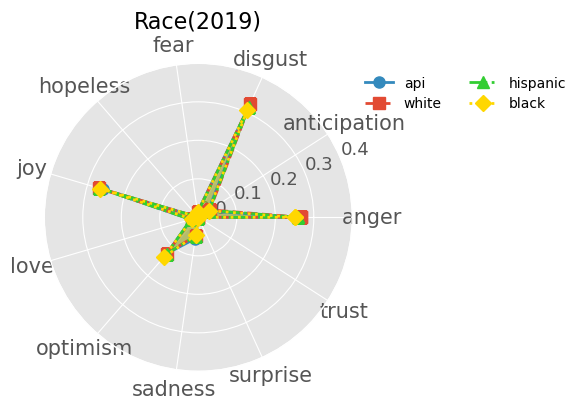

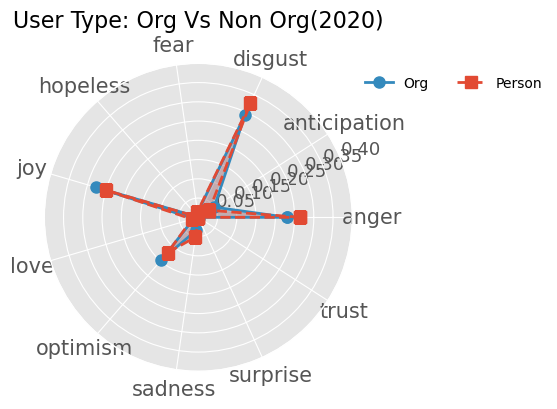

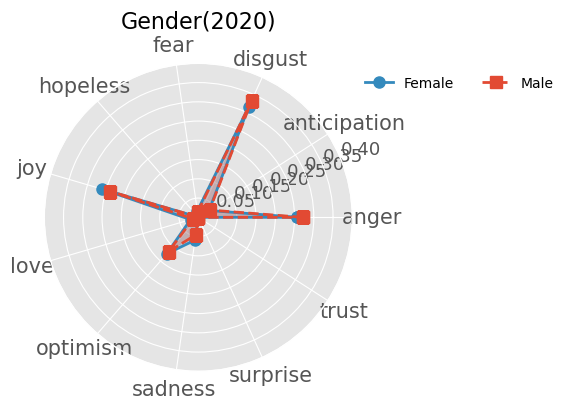

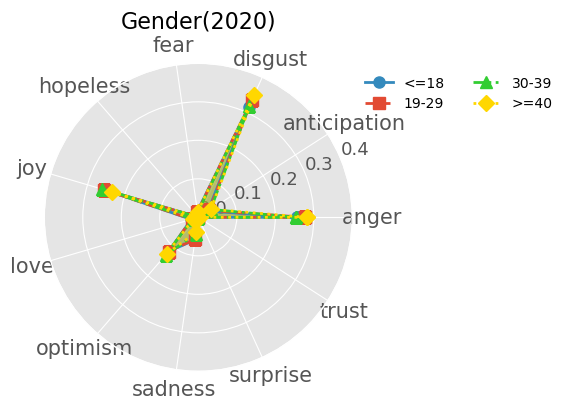

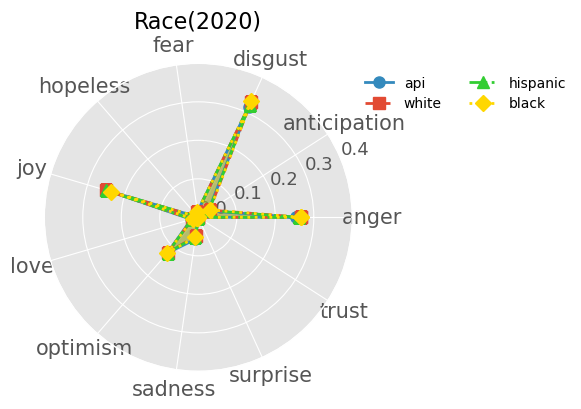

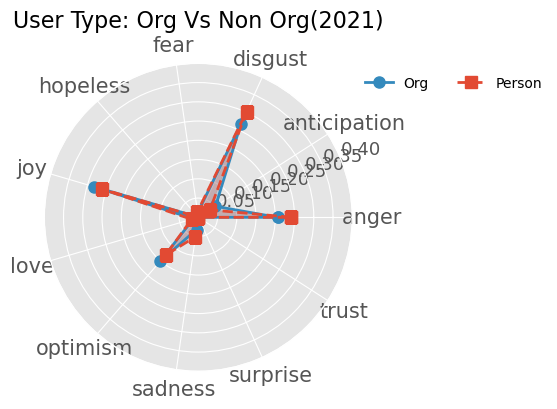

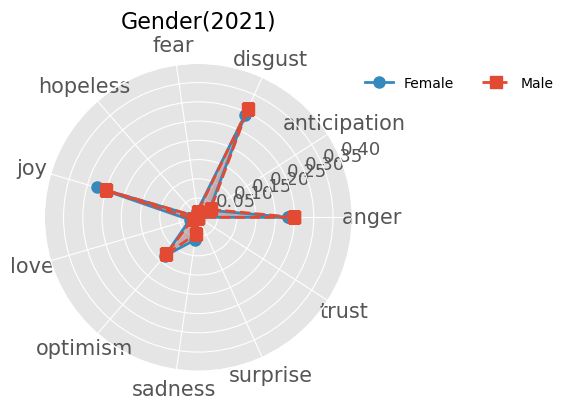

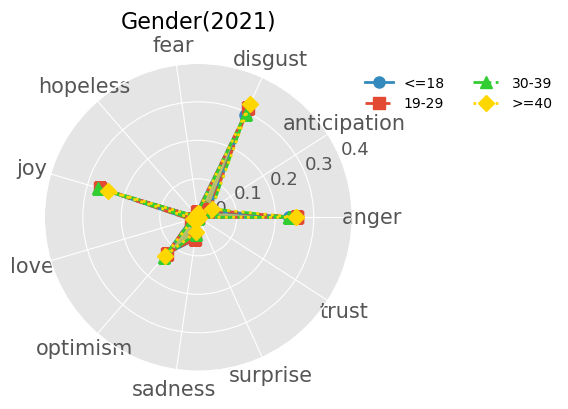

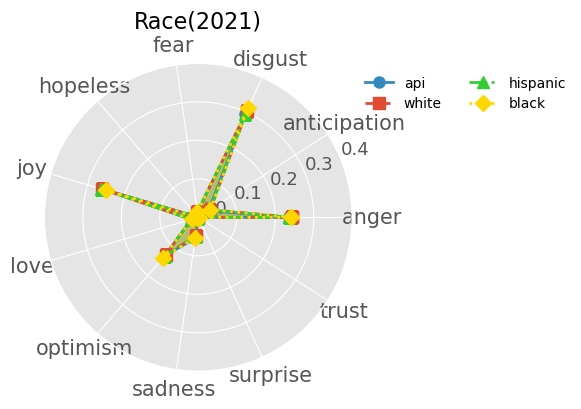

In [275]:
figures = {
           0: {'metric': ['Org', 'Person'], 'title': 'User Type: Org Vs Non Org'},
           1: {'metric':['Female', 'Male'], 'title': 'Gender'},
           2: {'metric':['<=18', '19-29', '30-39', '>=40'], 'title': 'Gender'}, 
           3: {'metric':['api', 'white', 'hispanic', 'black'], 'title': 'Race'}
          }
# fig, axs = plt.subplots(2, 2, figsize=(14, 14), subplot_kw=dict(polar=True))
# fig.subplots_adjust(hspace=0.3, wspace=0.3)

for year in years:
    combined_result = pd.concat(all_data[year], axis=1) 
    for i in range(len(figures.keys())):
        try:
            fig_temp = plt.figure(figsize=(4, 4))
            ax = fig_temp.add_subplot(111, polar=True)
            angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

            metrics = figures[i]['metric']
            title = figures[i]['title']
            values = []
            for j, m in enumerate(metrics):      
                values = combined_result[m].tolist()
                ax.plot(angles + angles[:1], values + values[:1], color=colors[j], linestyle=line_styles[j], marker=markers[j], markersize=8, linewidth=2, label=m)
                ax.fill(angles + angles[:1], values + values[:1], alpha=0.25, color=colors[j])

            ax.set_thetagrids(np.degrees(angles), feature)
            ax.set_ylim(0.0, ylim[i])  
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=13)
            if len(figures[i]['metric']) > 2:
                plt.yticks(np.arange(0.0, 0.5, step=0.1), fontsize=13)  # Set y-ticks to match the zoom level

            plt.title(title + f"({year})", fontsize=16)
            ax.grid(True)
            plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2, frameon=False, fancybox=True, shadow=False)
            figure_path = 'radio_plot' + str(i) + '.pdf'
            plt.rcParams.update({'font.family': 'DejaVu Sans'})
            plt.show()
        except Exception as e:
            print(e)

In [16]:
filename = "hello.csv"
filename=filename.replace(".csv", "_output.csv")
filename

'hello_output.csv'